# CODE TO IMPORT FOUNDATION MODEL

In [2]:
!git clone https://github.com/plana93/ARGO_Vision_CODEMOTION_2025.git
!pip install -e ARGO_Vision_CODEMOTION_2025
!pip install -q timm kornia

Cloning into 'ARGO_Vision_CODEMOTION_2025'...
remote: Enumerating objects: 213, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 213 (delta 9), reused 1 (delta 0), pack-reused 192 (from 1)
Receiving objects: 100% (213/213), 34.25 MiB | 30.50 MiB/s, done.
Resolving deltas: 100% (115/115), done.
Obtaining file:///content/ARGO_Vision_CODEMOTION_2025
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for CODEMOTION_2025 (pyproject.toml) ... done
  Created wheel for CODEMOTION_2025: filename=codemotion_2025-0.1.0-0.editable-py3-none-any.whl size=2903 sha256=64263d7b8bbf47f298e16425fe3a35ad7dd5ee13273a7b1a089e8b0aa265bbe2
  Stored in directory: /tmp/pip-ephem-wheel-cache-or612li3/wheels/5b/cb/24/68e4d6865367b2eb40d237767b8b626120727f49411638f36e
Success

In [4]:
import sys
import os
sys.path.append("../")
sys.path.append("./ARGO_Vision_CODEMOTION_2025")

from pathlib import Path
from typing import Optional, Tuple

import numpy as np
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from PIL import Image

import timm
import matplotlib.pyplot as plt

import kornia.morphology as km
import kornia.contrib as kc

from tqdm import tqdm

torch.set_grad_enabled(False)

from codemotion2025.utils.download_image import download_image_from_url
from codemotion2025.utils.dinov3_utils import (
    last_layer_patch_features as v3_last_layer_patch_features,
    get_dinov3_transform as v3_get_transform,
)


In [26]:
# https://s.hdnux.com/photos/01/36/56/03/24830199/1/998x0.jpg

# query https://preview.redd.it/curry-iconic-shots-moments-v0-00rt2cb4urid1.jpg?width=630&format=pjpg&auto=webp&s=b843506b2af05e18563e71d9dfff75ba6be62c6e
# support https://i.pinimg.com/736x/2d/9b/7c/2d9b7c23ee07100dc5096838b293468a.jpg


# query https://frontofficesports.com/wp-content/uploads/2023/02/FOS-23-2.20-NBA-Abu-Dhabi-Qatar.jpg
# support https://www.wilson.com/it-it/media/catalog/product/article_images/WTB7300XB_/WTB7300XB__a009b03f0c4e869e1bfbebca3e7cdebc.png

query_image_pre_bbox = download_image_from_url()
if query_image_pre_bbox and os.path.exists(query_image_pre_bbox):
    print(f"Using image file at: {query_image_pre_bbox}")
else:
    print("No valid image file is available.")

Enter the URL of an online image (or leave blank to use Colab upload): https://www.wilson.com/it-it/media/catalog/product/article_images/WTB7300XB_/WTB7300XB__a009b03f0c4e869e1bfbebca3e7cdebc.png
Downloaded and saved image as: downloads/img_0004.jpg
Using image file at: downloads/img_0004.jpg


In [7]:
# @title
# =========================
# DINOv3 (timm) 16×16 utils
# =========================
import math
from typing import Optional, Tuple, List

import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms.functional import InterpolationMode
import timm

import kornia.morphology as km
import kornia.contrib as kc


# ---------------------------
# Model & preprocessing (timm)
# ---------------------------
def load_dinov3(model_name: str, device: torch.device) -> torch.nn.Module:
    """
    Load a DINOv3 ViT backbone from timm and set it to eval mode.
    Examples:
      - 'vit_small_plus_patch16_dinov3_qkvb.lvd1689m'  (C=384)
      - 'vit_base_patch16_dinov3.lvd_1689m'            (C=768)
      - 'vit_large_patch16_dinov3_qkvb.lvd_1689m'      (C=1024)
    """
    model = timm.create_model(model_name, pretrained=True)
    model.eval().to(device)
    print(f"[load_dinov3] Loaded '{model_name}' on {device}.")
    return model


def dinov3_transform(model: torch.nn.Module, force_size: Optional[int] = None) -> T.Compose:
    """
    Build a preprocessing transform from timm's data config.
    If `force_size` is set (e.g. 256), it overrides the native input size.
    Always applies ImageNet mean/std normalization.
    """
    cfg = timm.data.resolve_model_data_config(model)
    if force_size is not None:
        cfg = {**cfg, "input_size": (3, force_size, force_size)}
    tfm = timm.data.create_transform(**cfg, is_training=False)
    print(f"[dinov3_transform] Using input_size={cfg.get('input_size')}  mean/std={cfg.get('mean')}/{cfg.get('std')}")
    return tfm


# ---------------------------
# Patch & resize helpers
# ---------------------------
def _infer_patch_size(model: torch.nn.Module) -> int:
    """Infer ViT patch size from model.patch_embed."""
    if not hasattr(model, "patch_embed"):
        raise RuntimeError("Model lacks 'patch_embed'.")
    pe = model.patch_embed
    if hasattr(pe, "proj") and hasattr(pe.proj, "kernel_size"):
        ks = pe.proj.kernel_size
        return ks[0] if isinstance(ks, (tuple, list)) else int(ks)
    if hasattr(pe, "patch_size"):
        return pe.patch_size if isinstance(pe.patch_size, int) else pe.patch_size[0]
    raise RuntimeError("Unable to infer patch size.")


def _nearest_multiple(n: int, base: int) -> int:
    """Round down to nearest multiple of `base`."""
    return (n // base) * base


def resize_to_multiple_of(image_chw: torch.Tensor, patch: int) -> Tuple[torch.Tensor, int, int]:
    """
    Resize a CHW image tensor to nearest multiple of `patch`.
    Returns: (image_resized, H_resized, W_resized)
    """
    H, W = image_chw.shape[-2:]
    Hn, Wn = _nearest_multiple(H, patch), _nearest_multiple(W, patch)
    if Hn == 0 or Wn == 0:
        raise ValueError(f"Image too small for patch {patch}: {H}x{W}")
    if (Hn, Wn) != (H, W):
        image_resized = T.functional.resize(image_chw, (Hn, Wn), interpolation=InterpolationMode.BICUBIC)
    else:
        image_resized = image_chw
    return image_resized, Hn, Wn


# ---------------------------
# Feature extraction (tokens → fmap)
# ---------------------------
@torch.no_grad()
def last_layer_patch_features_v3(
    model: torch.nn.Module,
    x_bchw: torch.Tensor,
    apply_norm: bool = True,
    verbose: bool = False,
) -> torch.Tensor:
    """
    Return the last-layer patch-aligned feature map (B, C, Hp, Wp) for DINOv3 (timm).
    Steps:
      1) forward_features → tokens (B, N_all, C)
      2) drop ALL prefix tokens (CLS + registers)
      3) reshape to (B, C, Hp, Wp)
      4) optional channel-wise LayerNorm (DINOv3-style)
    """
    ps = _infer_patch_size(model)
    H, W = x_bchw.shape[-2:]
    assert H % ps == 0 and W % ps == 0, f"Input {H}x{W} must be divisible by patch size {ps}."

    seq = model.forward_features(x_bchw)  # (B, N_all, C)
    if seq.dim() != 3:
        raise RuntimeError(f"Expected (B, N, C) from forward_features, got {tuple(seq.shape)}")

    B, N_all, C = seq.shape
    Hp, Wp = H // ps, W // ps
    n_patches = Hp * Wp
    n_prefix = getattr(model, "num_prefix_tokens", N_all - n_patches)
    if n_prefix < 0 or (N_all - n_prefix) != n_patches:
        raise RuntimeError(f"Token mismatch: total={N_all}, prefix={n_prefix}, patches={n_patches}")

    # Drop prefix tokens
    seq = seq[:, n_prefix:, :]  # (B, n_patches, C)
    fmap = seq.view(B, Hp, Wp, C).permute(0, 3, 1, 2).contiguous()  # (B, C, Hp, Wp)

    # Optional per-channel LN (as DINOv3 often applies before head)
    if apply_norm and hasattr(model, "norm") and isinstance(model.norm, torch.nn.LayerNorm):
        fmap = fmap.permute(0, 2, 3, 1).contiguous()  # (B, Hp, Wp, C)
        fmap = F.layer_norm(fmap, (C,))
        fmap = fmap.permute(0, 3, 1, 2).contiguous()  # (B, C, Hp, Wp)

    if verbose:
        print(f"[last_layer_patch_features_v3]")
        print(f"  input: {tuple(x_bchw.shape)}  patch={ps}  grid={Hp}x{Wp} (={n_patches})")
        print(f"  tokens: total={N_all}, prefix={n_prefix}, kept={seq.shape[1]}")
        print(f"  fmap: {tuple(fmap.shape)}  (B,C,Hp,Wp)")

    return fmap


@torch.no_grad()
def extract_from_layer_dinov3(
    image_chw_uint8: torch.Tensor,      # CHW in [0..255] or [0..1]
    model: torch.nn.Module,
    tfm: T.Compose,                     # timm transform (same for support/query/bg)
    device: torch.device,
    mask_hw: Optional[torch.Tensor] = None,
    force_resize_to_multiple_of_patch: bool = True,
    verbose: bool = False,
):
    """
    Extract last-layer feature map for DINOv3 (timm) with consistent preprocessing.
    - Applies `tfm` (timm) after optional resize-to-multiple-of-patch (to keep grids aligned).
    - Returns:
        * (C, Hp, Wp) if mask is None
        * (C,)        if mask is provided (masked average embedding)
    """
    ps = _infer_patch_size(model)  # expect 16
    img = image_chw_uint8

    # 0) (optional) coerce to multiple of patch before timm transform
    if force_resize_to_multiple_of_patch:
        img, Hn, Wn = resize_to_multiple_of(img, ps)
    else:
        Hn, Wn = img.shape[-2:]

    # 1) timm preprocessing (same for support/query/background)
    x = tfm(img)                # (3, Ht, Wt) float normalized
    x = x.unsqueeze(0).to(device)

    # 2) features @ last layer (B,C,Hp,Wp)
    fmap = last_layer_patch_features_v3(model, x, apply_norm=True, verbose=verbose).squeeze(0)  # (C, Hp, Wp)

    if verbose:
        print(f"[extract_from_layer_dinov3]")
        print(f"  in_img: {tuple(img.shape)}  after_tfm: {tuple(x.shape)}")
        print(f"  fmap: {tuple(fmap.shape)}  (C,Hp,Wp);  ps={ps};  grid={fmap.shape[1]}x{fmap.shape[2]}")

    # 3) masked average → (C,)
    if mask_hw is not None:
        Hp, Wp = fmap.shape[1:]
        mask_patch = T.functional.resize(
            mask_hw.unsqueeze(0).unsqueeze(0).float(),
            size=(Hp, Wp),
            interpolation=InterpolationMode.NEAREST
        ).squeeze()
        w = (mask_patch > 0).float()             # (Hp, Wp)
        if w.sum() < 1:
            if verbose:
                print("[extract_from_layer_dinov3] mask empty after resize → falling back to global average.")
            return fmap.view(fmap.shape[0], -1).mean(dim=1)
        f2d = fmap.view(fmap.shape[0], -1)       # (C, Hp*Wp)
        emb = (f2d * w.view(-1)).sum(dim=1) / (w.sum() + 1e-8)  # (C,)
        if verbose:
            print(f"  masked emb: {tuple(emb.shape)}  (C,)  pos_frac={w.mean().item():.4f}")
        return emb

    return fmap  # (C, Hp, Wp)


# ---------------------------
# Similarities + background grid alignment
# ---------------------------
def compute_similarity_map(
    fmap_chw: torch.Tensor,     # (C, Hp, Wp)
    embedding_c: torch.Tensor,  # (C,)
    normalize: bool = True,
    tag: str = "S(Q|S_emb)"
) -> torch.Tensor:
    """
    Cosine similarity per patch with a single embedding.
    """
    C, Hp, Wp = fmap_chw.shape
    f2d = fmap_chw.view(C, -1)
    f2d = f2d / (f2d.norm(p=2, dim=0, keepdim=True) + 1e-8)
    emb = embedding_c / (embedding_c.norm(p=2) + 1e-8)
    sim = (f2d * emb[:, None]).sum(dim=0).view(Hp, Wp)
    if normalize:
        smin, smax = sim.amin(), sim.amax()
        sim = (sim - smin) / (smax - smin + 1e-12) if (smax > smin) else torch.zeros_like(sim)
    print(f"[sim-map {tag}] shape={tuple(sim.shape)}  min={sim.min().item():.4f}  max={sim.max().item():.4f}  mean={sim.mean().item():.4f}  std={sim.std().item():.4f}")
    return sim


def compute_spatially_aligned_similarity_map(
    fmap1_chw: torch.Tensor,   # (C, H, W)
    fmap2_chw: torch.Tensor,   # (C, H, W)
    normalize: bool = True,
    tag: str = "S(Q|B_fmap)"
) -> torch.Tensor:
    """
    Cosine similarity for corresponding spatial locations (requires same grid).
    """
    if fmap1_chw.shape != fmap2_chw.shape:
        raise ValueError(f"Spatial maps must match: {tuple(fmap1_chw.shape)} vs {tuple(fmap2_chw.shape)}")

    C, H, W = fmap1_chw.shape
    F1 = fmap1_chw.view(C, -1)
    F2 = fmap2_chw.view(C, -1)
    F1 = F1 / (F1.norm(p=2, dim=0, keepdim=True) + 1e-8)
    F2 = F2 / (F2.norm(p=2, dim=0, keepdim=True) + 1e-8)

    sim = (F1 * F2).sum(dim=0).view(H, W)
    if normalize:
        smin, smax = sim.amin(), sim.amax()
        sim = (sim - smin) / (smax - smin + 1e-12) if (smax > smin) else torch.zeros_like(sim)
    print(f"[sim-map {tag}] shape={tuple(sim.shape)}  min={sim.min().item():.4f}  max={sim.max().item():.4f}  mean={sim.mean().item():.4f}  std={sim.std().item():.4f}")
    return sim


def align_background_grid_to_query(
    bg_fmap_chw: torch.Tensor,   # (C, Hb, Wb)
    q_fmap_chw: torch.Tensor     # (C, Hq, Wq)
) -> torch.Tensor:
    """
    If background fmap grid != query grid, interpolate background fmap spatially to match query grid.
    Keeps channels as-is. Uses bilinear interpolation.
    """
    C1, Hb, Wb = bg_fmap_chw.shape
    C2, Hq, Wq = q_fmap_chw.shape
    assert C1 == C2, f"Channel mismatch: {C1} vs {C2}"
    if (Hb, Wb) == (Hq, Wq):
        print(f"[align_bg] Already aligned: bg={Hb}x{Wb}, q={Hq}x{Wq}")
        return bg_fmap_chw
    bg = bg_fmap_chw.unsqueeze(0)  # (1,C,Hb,Wb)
    bg_aligned = F.interpolate(bg, size=(Hq, Wq), mode="bilinear", align_corners=False).squeeze(0)
    print(f"[align_bg] Resampled background fmap: {Hb}x{Wb} -> {Hq}x{Wq}")
    return bg_aligned


# ---------------------------
# Mask extraction (+ prints)
# ---------------------------
def extract_mask(
    sim_hw: torch.Tensor,                      # (Hp, Wp)
    mode: str = "threshold",                   # 'threshold' | 'topk%'
    *,
    tval: float = 0.5,                         # threshold OR percent (0..1) for topk%
    blur: bool = False,
    threshold_type: str = "static",            # 'static' | 'mean_std' | 'max'
    closing_kernel_size: int = 0,
    kernel_size: Optional[int] = None,
    min_area: int = 0,
    num_ccl_iterations: int = 100,
    keep_largest_cc: bool = False,             # <--- NEW
) -> torch.Tensor:
    """
    Convert a similarity map (Hp, Wp) into a binary mask (Hp, Wp).
    Optionally keep only the largest connected component.
    """
    assert sim_hw.ndim == 2, "sim_hw must be (Hp, Wp)."
    s = sim_hw
    if blur:
        s = torch.nn.functional.gaussian_blur(s.unsqueeze(0).unsqueeze(0), (5, 5), sigma=1).squeeze()

    if mode == "threshold":
        if threshold_type == "static":
            thr = tval
        elif threshold_type == "mean_std":
            thr = s.mean().item() + tval * s.std().item()
        elif threshold_type == "max":
            thr = tval * s.max().item()
        else:
            raise ValueError(f"Unknown threshold_type: {threshold_type}")
        mask = (s >= thr).to(torch.uint8)
        print(f"[mask] mode=threshold type={threshold_type} thr={thr:.4f}")
    elif mode == "topk%":
        k = max(int(s.numel() * tval), 1)
        topk_vals, _ = torch.topk(s.flatten(), k)
        thr = topk_vals[-1]
        mask = (s >= thr).to(torch.uint8)
        print(f"[mask] mode=topk% k={k} thr={thr.item():.4f}")
    else:
        raise ValueError(f"Unknown mode: {mode}")

    if closing_kernel_size > 0:
        ksz = kernel_size or closing_kernel_size
        kernel = torch.ones(ksz, ksz, device=mask.device, dtype=torch.float32)
        mask = km.closing(mask.float().unsqueeze(0).unsqueeze(0), kernel).squeeze().to(torch.uint8)

    pos_ratio = mask.float().mean().item()
    print(f"[mask] shape={tuple(mask.shape)}  pos_ratio={pos_ratio:.4f}")

    # --- keep only largest connected component (optional) ---
    if keep_largest_cc and mask.any():
        mk = mask.float().unsqueeze(0).unsqueeze(0)
        labels = kc.connected_components(mk, num_iterations=num_ccl_iterations).squeeze().long()
        areas = torch.bincount(labels.flatten())
        # ignore label 0 (background)
        if areas.numel() > 1:
            areas[0] = 0
            largest = torch.argmax(areas)
            mask = (labels == largest).to(torch.uint8)
            pos_ratio = mask.float().mean().item()
            print(f"[mask] kept largest CC (label={largest.item()}) pos_ratio={pos_ratio:.4f}")

    if min_area > 0:
        mk = mask.float().unsqueeze(0).unsqueeze(0)
        labels = kc.connected_components(mk, num_iterations=num_ccl_iterations).squeeze().long()
        areas = torch.bincount(labels.flatten())
        keep = (areas >= min_area).nonzero().squeeze(1)
        keep = keep[keep != 0]
        if keep.numel() == 0:
            print(f"[mask] area filtering removed all. min_area={min_area}")
            return torch.zeros_like(mask)
        mask = torch.isin(labels, keep).to(torch.uint8)
        print(f"[mask] after area filtering: pos_ratio={mask.float().mean().item():.4f}")

    if pos_ratio < 1e-3:
        print("[hint] Mask empty-ish. Try normalize=True, threshold_type='max' with tval in [0.5..0.8], or mode='topk%' with tval~0.01")
    elif pos_ratio > 0.99:
        print("[hint] Mask full-ish. Try lower tval or threshold_type='mean_std' with tval≈1.0")

    return mask


# ---------------------------
# Background fmap averaging
# ---------------------------
@torch.no_grad()
def build_background_fmap(
    bg_images_chw: List[torch.Tensor],
    model: torch.nn.Module,
    tfm: T.Compose,
    device: torch.device,
) -> torch.Tensor:
    """
    Average background feature maps (C,H,W) over multiple images → (C,H,W).
    All images pass through the same tfm (consistent preprocessing).
    Grids are upsampled to the largest among them before averaging.
    """
    fmap_list = []
    for k, img in enumerate(bg_images_chw):
        Fb = extract_from_layer_dinov3(img.to(device), model, tfm, device, mask_hw=None, verbose=False)
        fmap_list.append(Fb)
        print(f"[bg] #{k} fmap: {tuple(Fb.shape)}")

    # harmonize spatial sizes before averaging
    Hmax = max(f.shape[1] for f in fmap_list)
    Wmax = max(f.shape[2] for f in fmap_list)
    fmap_resized = []
    for f in fmap_list:
        if (f.shape[1], f.shape[2]) != (Hmax, Wmax):
            fmap_resized.append(F.interpolate(f.unsqueeze(0), size=(Hmax, Wmax), mode="bilinear", align_corners=False).squeeze(0))
            print(f"[bg] resized one fmap to {Hmax}x{Wmax}")
        else:
            fmap_resized.append(f)
    Fbg = torch.stack(fmap_resized, dim=0).mean(dim=0)  # (C, Hmax, Wmax)
    print(f"[bg] averaged fmap: {tuple(Fbg.shape)}")
    return Fbg


# ---------------------------
# One-pair sanity check (optional)
# ---------------------------
def sanity_check_pair(
    support_img_chw: torch.Tensor,
    query_img_chw: torch.Tensor,
    model: torch.nn.Module,
    tfm: T.Compose,
    device: torch.device,
    support_mask_hw: Optional[torch.Tensor] = None,
    normalize_sim: bool = True,
):
    print("=== SANITY CHECK (one pair) ===")
    # features
    Fq = extract_from_layer_dinov3(query_img_chw.to(device),   model, tfm, device, mask_hw=None, verbose=True)
    Fs = extract_from_layer_dinov3(support_img_chw.to(device), model, tfm, device, mask_hw=None, verbose=True)

    # embedding (masked or global)
    if support_mask_hw is not None:
        S_emb = extract_from_layer_dinov3(support_img_chw.to(device), model, tfm, device, mask_hw=support_mask_hw, verbose=True)
        print(f"[sanity] Support EMB: {tuple(S_emb.shape)} (C,)")
    else:
        S_emb = Fs.view(Fs.shape[0], -1).mean(dim=1)
        print(f"[sanity] Support EMB (global avg): {tuple(S_emb.shape)} (C,)")

    # sim on query
    S = compute_similarity_map(Fq, S_emb, normalize=normalize_sim, tag="S(Q|S_emb)")
    print(f"[sanity] S shape={tuple(S.shape)}  stats: min={S.min().item():.4f}, max={S.max().item():.4f}, mean={S.mean().item():.4f}")
    return Fq, Fs, S_emb, S


In [30]:
# =========================
# Config
# =========================

# Paths (set these to your files)
QUERY_IMAGE_PATH   = Path("/content/downloads/img_0003.jpg")
SUPPORT_IMAGE_PATH = Path("/content/downloads/img_0004.jpg")
# Optional: binary mask (PNG/JPG) for the support object (same space as SUPPORT_IMAGE_PATH)
SUPPORT_MASK_PATH  = None  # e.g., Path("/content/support_mask.png") or None

MODEL_DINOV3_VITSP = "vit_small_plus_patch16_dinov3_qkvb.lvd1689m"

# DINOv3 backbone (C depends on the variant)
MODEL_NAME = MODEL_DINOV3_VITSP  # ViT-L/16 → C=1024
INPUT_SIZE = 1024                                        # common for LVD-1689M; set None for native
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Mask extraction hyper-parameters
MASK_MODE            = "threshold"   # 'threshold' or 'topk%'
THRESH_VALUE         = 0.6           # if 'threshold' + 'static': direct threshold; if 'topk%': percent (0..1)
THRESHOLD_TYPE       = "max"      # 'static' | 'mean_std' | 'max'
MORPH_CLOSING_KSIZE  = 0             # 0 to disable
SMALL_COMPONENT_AREA = 0            # 0 to disable

KEEP_LARGEST_CC = False


In [28]:
# @title
# # =========================
# # Pipeline
# # =========================

# # 1) Load model and transforms
# model = load_dinov3(MODEL_NAME, DEVICE)
# transform = dinov3_transform(model, force_size=INPUT_SIZE)

# # 2) Load images
# q_pil = read_rgb(QUERY_IMAGE_PATH)
# s_pil = read_rgb(SUPPORT_IMAGE_PATH)
# q_np  = np.array(q_pil)  # keep originals for visualization

# # 3) Preprocess → tensors (1, 3, H, W)
# q_x = pil_to_model_tensor(q_pil, transform, DEVICE)
# s_x = pil_to_model_tensor(s_pil, transform, DEVICE)

# # 4) Feature maps (C, Hp, Wp)
# q_fmap = extract_feature_map(model, q_x)
# s_fmap = extract_feature_map(model, s_x)

# # 5) Build a support embedding (from mask if provided, else global average)
# if SUPPORT_MASK_PATH is not None:
#     m_pil = Image.open(str(SUPPORT_MASK_PATH)).convert("L")
#     m_np  = (np.array(m_pil) > 127).astype(np.uint8)  # binarize
#     m_t   = torch.from_numpy(m_np)                    # (Hs_img, Ws_img)
#     s_emb = average_embedding_from_mask(s_fmap, m_t)  # (C,)
# else:
#     s_emb = s_fmap.view(s_fmap.shape[0], -1).mean(dim=1)  # (C,)

# # 6) Similarity on the query
# q_sim = compute_similarity_map(q_fmap, s_emb, normalize=True)  # (Hq, Wq)

# # 7) Threshold to get a patch-level binary mask
# q_mask_patch = extract_mask(
#     q_sim,
#     mode=MASK_MODE,
#     tval=THRESH_VALUE,
#     threshold_type=THRESHOLD_TYPE,
#     closing_kernel_size=MORPH_CLOSING_KSIZE,
#     min_area=SMALL_COMPONENT_AREA,
# )

# # 8) Upsample mask to image resolution (for visualization)
# q_mask_img = upsample_to_image(q_mask_patch, target_hw=(q_np.shape[0], q_np.shape[1])).cpu().numpy()

# # 9) Visualize: query image, similarity heatmap, overlay
# fig, axs = plt.subplots(1, 3, figsize=(16, 6))
# axs[0].imshow(q_np); axs[0].set_title("Query image"); axs[0].axis("off")

# im1 = axs[1].imshow(q_sim.cpu().numpy(), cmap="magma")
# axs[1].set_title("Patch similarity"); axs[1].axis("off")
# fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# overlay = overlay_mask_on_image(q_np, q_mask_img, alpha=0.5)
# axs[2].imshow(overlay); axs[2].set_title("Segmentation overlay"); axs[2].axis("off")

# plt.tight_layout()
# plt.show()

# print(f"Feature dim (C): {q_fmap.shape[0]}")
# print(f"Query grid: {tuple(q_fmap.shape[1:])} | Support grid: {tuple(s_fmap.shape[1:])}")


[load_dinov3] Loaded 'vit_small_plus_patch16_dinov3_qkvb.lvd1689m' on cpu.
[dinov3_transform] Using input_size=(3, 1024, 1024)  mean/std=(0.485, 0.456, 0.406)/(0.229, 0.224, 0.225)
[last_layer_patch_features_v3]
  input: (1, 3, 1024, 1024)  patch=16  grid=64x64 (=4096)
  tokens: total=4101, prefix=5, kept=4096
  fmap: (1, 384, 64, 64)  (B,C,Hp,Wp)
[extract_from_layer_dinov3]
  in_img: (3, 992, 1488)  after_tfm: (1, 3, 1024, 1024)
  fmap: (384, 64, 64)  (C,Hp,Wp);  ps=16;  grid=64x64
[last_layer_patch_features_v3]
  input: (1, 3, 1024, 1024)  patch=16  grid=64x64 (=4096)
  tokens: total=4101, prefix=5, kept=4096
  fmap: (1, 384, 64, 64)  (B,C,Hp,Wp)
[extract_from_layer_dinov3]
  in_img: (3, 640, 640)  after_tfm: (1, 3, 1024, 1024)
  fmap: (384, 64, 64)  (C,Hp,Wp);  ps=16;  grid=64x64
[DEBUG] Feature dim (C): 384
[DEBUG] Query grid: (64, 64) | Support grid: (64, 64)
[sim-map S(Q|S_emb)] shape=(64, 64)  min=0.0000  max=1.0000  mean=0.2959  std=0.1085
[DEBUG] q_sim stats: min=0.0000  max=1

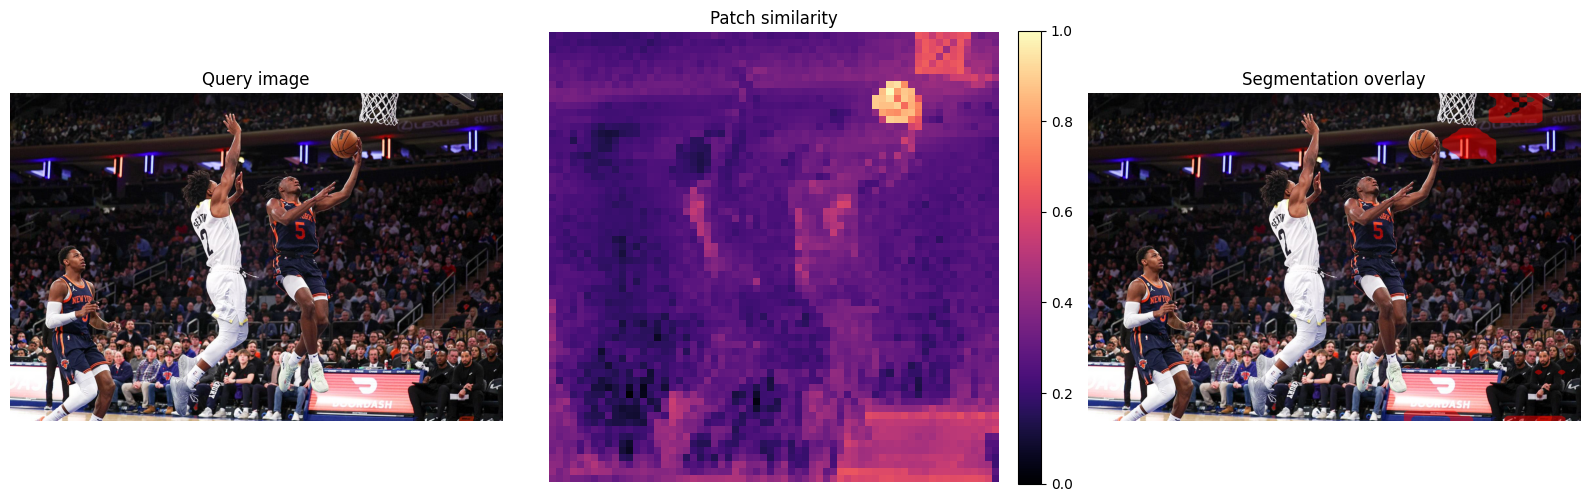

In [34]:
# =========================
# Pipeline
# =========================
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# --- tiny helpers for this cell ---

def read_rgb(path):
    """Read an image from disk as RGB PIL.Image."""
    return Image.open(str(path)).convert("RGB")

def pil_to_chw_tensor_uint01(pil_img):
    """Convert PIL RGB to CHW float tensor in [0,1]."""
    arr = np.array(pil_img)             # H, W, 3  uint8
    t = torch.from_numpy(arr).permute(2, 0, 1).float() / 255.0
    return t  # (3,H,W) in [0,1]

def upsample_to_image(mask_hw, target_hw):
    """Upsample a (Hp,Wp) mask to (H,W) with nearest."""
    H, W = target_hw
    m = mask_hw.unsqueeze(0).unsqueeze(0).float()    # 1x1xHp xWp
    m_up = F.interpolate(m, size=(H, W), mode="nearest").squeeze(0).squeeze(0)
    return (m_up > 0.5).to(torch.uint8)              # keep it binary

def overlay_mask_on_image(img_np, mask_np, alpha=0.5):
    """
    Overlay a binary mask (H,W) over an RGB image (H,W,3) with a red tint.
    img_np can be uint8 or float [0..1].
    """
    if img_np.dtype != np.uint8:
        base = (np.clip(img_np, 0, 1) * 255).astype(np.uint8)
    else:
        base = img_np.copy()
    color = np.zeros_like(base)
    color[..., 0] = 255  # red
    m3 = np.repeat(mask_np[..., None], 3, axis=2)
    out = base.copy()
    out[m3.astype(bool)] = (
        (1 - alpha) * base[m3.astype(bool)] + alpha * color[m3.astype(bool)]
    ).astype(np.uint8)
    return out

# 1) Load model and transforms
model = load_dinov3(MODEL_NAME, DEVICE)                       # e.g. 'vit_small_plus_patch16_dinov3_qkvb.lvd1689m'
transform = dinov3_transform(model, force_size=INPUT_SIZE)    # e.g. INPUT_SIZE=256 (coerente per tutte le immagini)

# 2) Load images
q_pil = read_rgb(QUERY_IMAGE_PATH)
s_pil = read_rgb(SUPPORT_IMAGE_PATH)
q_np  = np.array(q_pil)  # keep originals for visualization

# 3) Preprocess → CHW tensors in [0,1] (prima del tfm di timm, che verrà applicato in extract_from_layer_dinov3)
q_chw = pil_to_chw_tensor_uint01(q_pil)            # (3,H,W)
s_chw = pil_to_chw_tensor_uint01(s_pil)            # (3,H,W)

# 4) Feature maps (C, Hp, Wp) — also to inspect grid sizes
q_fmap = extract_from_layer_dinov3(q_chw.to(DEVICE), model, transform, DEVICE, mask_hw=None, verbose=True)
s_fmap = extract_from_layer_dinov3(s_chw.to(DEVICE), model, transform, DEVICE, mask_hw=None, verbose=True)

# 5) Build a support embedding (from mask if provided, else global average)
if SUPPORT_MASK_PATH is not None:
    m_pil = Image.open(str(SUPPORT_MASK_PATH)).convert("L")
    m_np  = (np.array(m_pil) > 127).astype(np.uint8)      # binarize at 128
    m_t   = torch.from_numpy(m_np)                        # (Hs_img, Ws_img)

    # Use the masked averaging path directly from the support image (robust to grid):
    s_emb = extract_from_layer_dinov3(
        s_chw.to(DEVICE), model, transform, DEVICE,
        mask_hw=m_t.to(DEVICE), verbose=True
    )  # (C,)
else:
    # Global average over support fmap
    s_emb = s_fmap.view(s_fmap.shape[0], -1).mean(dim=1)  # (C,)

print(f"[DEBUG] Feature dim (C): {q_fmap.shape[0]}")
print(f"[DEBUG] Query grid: {tuple(q_fmap.shape[1:])} | Support grid: {tuple(s_fmap.shape[1:])}")

# 6) Similarity on the query
q_sim = compute_similarity_map(q_fmap, s_emb, normalize=True)  # (Hq, Wq)
print(f"[DEBUG] q_sim stats: min={q_sim.min().item():.4f}  max={q_sim.max().item():.4f}  mean={q_sim.mean().item():.4f}  std={q_sim.std().item():.4f}")

# 7) Threshold to get a patch-level binary mask
q_mask_patch = extract_mask(
    q_sim,
    mode=MASK_MODE,                      # "threshold" | "topk%"
    tval=THRESH_VALUE,                   # float; if threshold_type='max' try 0.7; if topk% try 0.02
    threshold_type=THRESHOLD_TYPE,       # "static" | "mean_std" | "max"
    closing_kernel_size=MORPH_CLOSING_KSIZE,
    min_area=SMALL_COMPONENT_AREA,
    keep_largest_cc=KEEP_LARGEST_CC,     # <--- opzionale, True se un solo oggetto
)
print(f"[DEBUG] q_mask_patch pos_ratio={q_mask_patch.float().mean().item():.4f}")





# 8) Upsample mask to image resolution (for visualization)
q_mask_img = upsample_to_image(q_mask_patch, target_hw=(q_np.shape[0], q_np.shape[1])).cpu().numpy()


img_tfm = transform(q_chw)   # tensor pre-processato
print("[DEBUG] Input to model shape:", img_tfm.shape)  # (3, Ht, Wt)
Ht, Wt = img_tfm.shape[-2:]             # size seen by the model
H_orig, W_orig = q_np.shape[:2]         # original image size
print(f"[DEBUG] Query image shape      : {q_np.shape}")
print(f"[DEBUG] Model input size       : {Ht, Wt}")
print(f"[DEBUG] Patch feature map shape: {q_fmap.shape[1:]}")
print(f"[DEBUG] Final mask shape       : {q_mask_img.shape}")


# 9) Visualize: query image, similarity heatmap, overlay
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
axs[0].imshow(q_np); axs[0].set_title("Query image"); axs[0].axis("off")

im1 = axs[1].imshow(q_sim.cpu().numpy(), cmap="magma")
axs[1].set_title("Patch similarity"); axs[1].axis("off")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

overlay = overlay_mask_on_image(q_np, q_mask_img, alpha=0.5)
axs[2].imshow(overlay); axs[2].set_title("Segmentation overlay"); axs[2].axis("off")

plt.tight_layout()
plt.show()



[load_dinov3] Loaded 'vit_small_plus_patch16_dinov3_qkvb.lvd1689m' on cpu.
[dinov3_transform] Using input_size=(3, 1024, 1024)  mean/std=(0.485, 0.456, 0.406)/(0.229, 0.224, 0.225)
[last_layer_patch_features_v3]
  input: (1, 3, 1024, 1024)  patch=16  grid=64x64 (=4096)
  tokens: total=4101, prefix=5, kept=4096
  fmap: (1, 384, 64, 64)  (B,C,Hp,Wp)
[extract_from_layer_dinov3]
  in_img: (3, 992, 1488)  after_tfm: (1, 3, 1024, 1024)
  fmap: (384, 64, 64)  (C,Hp,Wp);  ps=16;  grid=64x64
[last_layer_patch_features_v3]
  input: (1, 3, 1024, 1024)  patch=16  grid=64x64 (=4096)
  tokens: total=4101, prefix=5, kept=4096
  fmap: (1, 384, 64, 64)  (B,C,Hp,Wp)
[extract_from_layer_dinov3]
  in_img: (3, 640, 640)  after_tfm: (1, 3, 1024, 1024)
  fmap: (384, 64, 64)  (C,Hp,Wp);  ps=16;  grid=64x64
[DEBUG] Feature dim (C): 384
[DEBUG] Query grid: (64, 64) | Support grid: (64, 64)
[sim-map S(Q|S_emb)] shape=(64, 64)  min=0.0000  max=1.0000  mean=0.2959  std=0.1085
[DEBUG] q_sim stats: min=0.0000  max=1

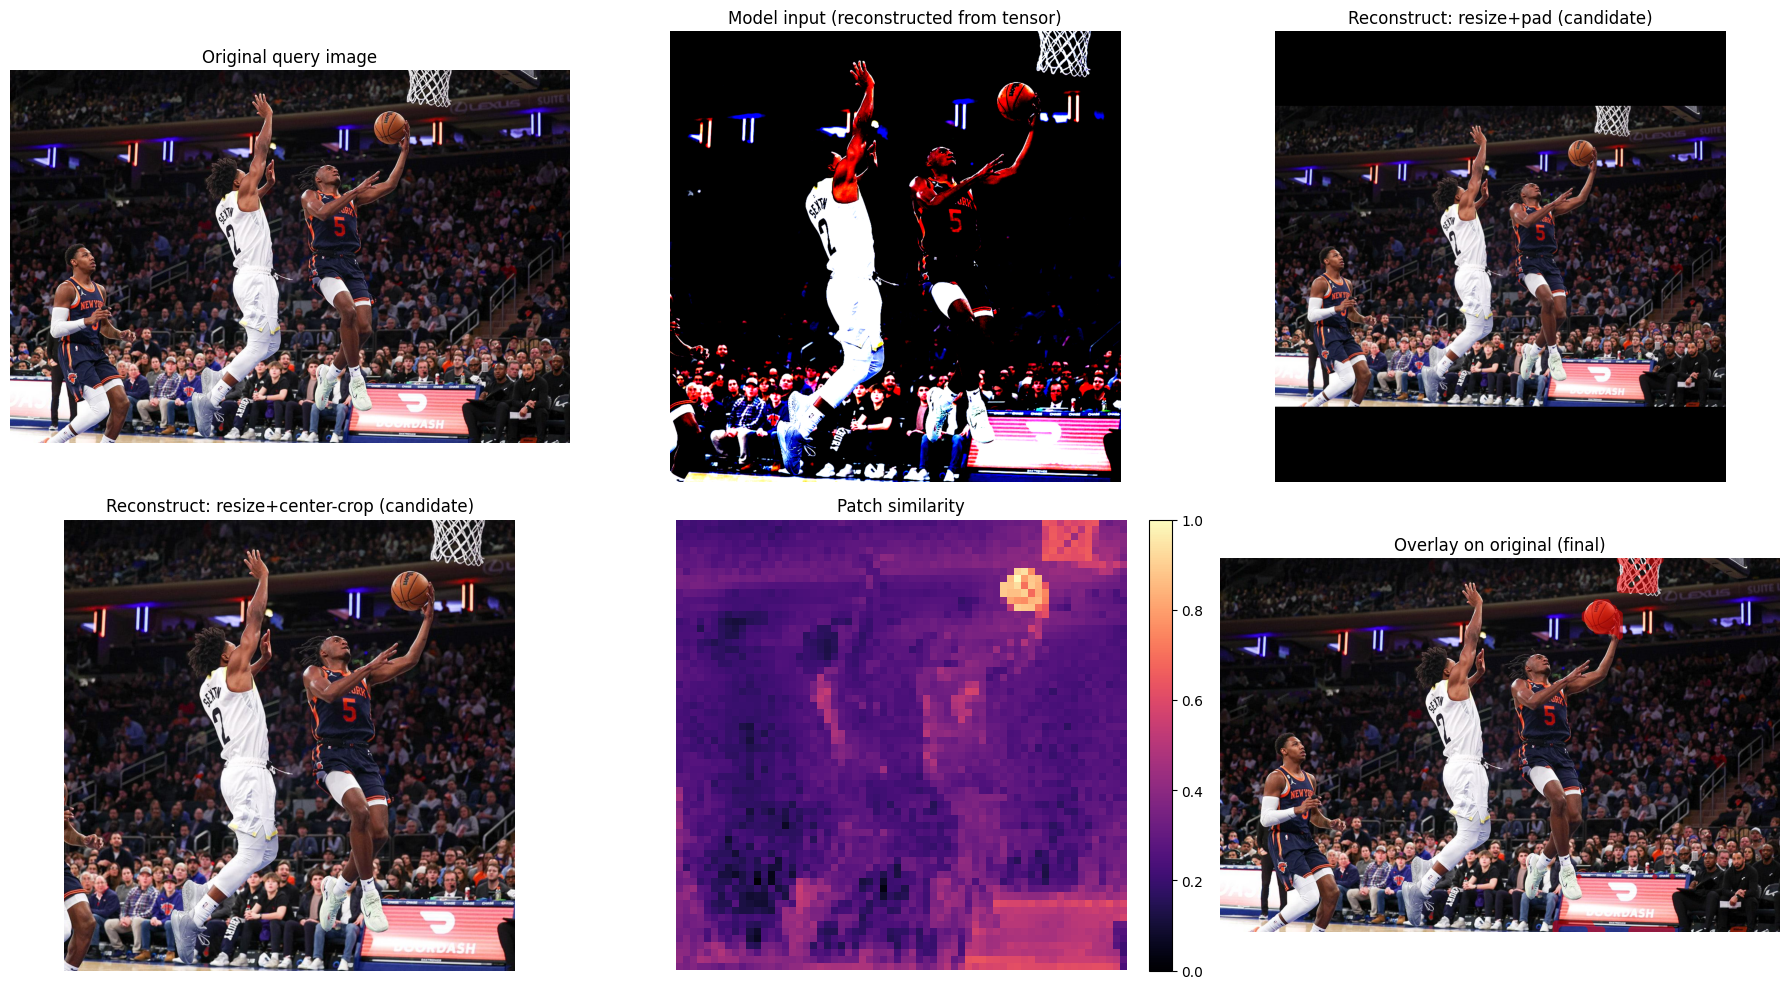

[DEBUG] original shape: (1000, 1500, 3), model-input shape: (1024, 1024, 3), patch-grid: (64, 64)
[DEBUG] model-space mask shape: (1024, 1024), final mask shape (original coords): (1000, 1500)
[DEBUG] total positive pixels: 21666  ratio: 0.0144


In [45]:
# =========================
# Pipeline (full cell)
# =========================
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path

# --- tiny helpers for this cell ---

def read_rgb(path):
    """Read an image from disk as RGB PIL.Image."""
    return Image.open(str(path)).convert("RGB")

def pil_to_chw_tensor_uint01(pil_img):
    """Convert PIL RGB to CHW float tensor in [0,1]."""
    arr = np.array(pil_img)             # H, W, 3  uint8
    t = torch.from_numpy(arr).permute(2, 0, 1).float() / 255.0
    return t  # (3,H,W) in [0,1]

def overlay_mask_on_image(img_np, mask_np, alpha=0.5):
    """
    Overlay a binary mask (H,W) over an RGB image (H,W,3) with a red tint.
    img_np can be uint8 or float [0..1].
    """
    if img_np.dtype != np.uint8:
        base = (np.clip(img_np, 0, 1) * 255).astype(np.uint8)
    else:
        base = img_np.copy()
    color = np.zeros_like(base)
    color[..., 0] = 255  # red
    m3 = np.repeat(mask_np[..., None], 3, axis=2)
    out = base.copy()
    mask_bool = m3.astype(bool)
    out[mask_bool] = (
        (1 - alpha) * base[mask_bool] + alpha * color[mask_bool]
    ).astype(np.uint8)
    return out

def unnormalize_tensor_to_uint8(img_tensor, mean=None, std=None):
    """
    Convert a normalized model input tensor (C,H,W) back to uint8 HxW x 3.
    If mean/std provided (tensors or lists), use them; otherwise try ImageNet heuristic.
    """
    t = img_tensor.detach().cpu().clone()
    if mean is None or std is None:
        mean = torch.tensor([0.485, 0.456, 0.406], dtype=t.dtype)
        std  = torch.tensor([0.229, 0.224, 0.225], dtype=t.dtype)
    # If tensor looks already in [0,1], skip inverse but still clamp
    if t.max() > 2.0 or t.min() < -2.0:
        # assume already unnormalized - do nothing
        pass
    else:
        try:
            t = t * std[:, None, None] + mean[:, None, None]
        except Exception:
            pass
    t = torch.clamp(t, 0.0, 1.0)
    arr = (t.permute(1, 2, 0).numpy() * 255.0).astype(np.uint8)
    return arr

# ----------------------
# remapping helpers
# ----------------------

def _reconstruct_resize_then_pad(q_np, target_hw):
    """
    Simulate: resize original keeping aspect (scale = min) then pad to target.
    Returns reconstructed model-input image (Ht,Wt,3) uint8 and params.
    """
    H_orig, W_orig = q_np.shape[:2]
    Ht, Wt = target_hw
    scale = min(Wt / W_orig, Ht / H_orig)
    new_w = int(round(W_orig * scale))
    new_h = int(round(H_orig * scale))
    left = (Wt - new_w) // 2
    top = (Ht - new_h) // 2
    # resize then pad
    resized = Image.fromarray(q_np).resize((new_w, new_h), resample=Image.BILINEAR)
    canvas = Image.new("RGB", (Wt, Ht), (0,0,0))
    canvas.paste(resized, (left, top))
    recon = np.array(canvas)
    params = dict(mode="pad", scale=scale, new_w=new_w, new_h=new_h, left=left, top=top)
    return recon, params

def _reconstruct_resize_then_center_crop(q_np, target_hw):
    """
    Simulate: resize original keeping aspect (scale = max) then center-crop to target.
    Returns reconstructed model-input image (Ht,Wt,3) uint8 and params.
    """
    H_orig, W_orig = q_np.shape[:2]
    Ht, Wt = target_hw
    scale = max(Wt / W_orig, Ht / H_orig)
    new_w = int(round(W_orig * scale))
    new_h = int(round(H_orig * scale))
    # resize larger, then center-crop
    resized = Image.fromarray(q_np).resize((new_w, new_h), resample=Image.BILINEAR)
    left = (new_w - Wt) // 2
    top = (new_h - Ht) // 2
    cropped = resized.crop((left, top, left + Wt, top + Ht))
    recon = np.array(cropped)
    params = dict(mode="crop", scale=scale, new_w=new_w, new_h=new_h, left=left, top=top)
    return recon, params

def _mask_from_model_space_to_orig_via_pad(mask_tfm, params, orig_hw):
    """
    mask_tfm: np.uint8 (Ht,Wt) binary
    params from pad reconstruction
    """
    H_orig, W_orig = orig_hw
    y0, x0 = params['top'], params['left']
    y1, x1 = y0 + params['new_h'], x0 + params['new_w']
    # crop region containing scaled original
    mask_crop = mask_tfm[y0:y1, x0:x1]
    # resize crop to original size
    mask_crop_t = torch.from_numpy(mask_crop).unsqueeze(0).unsqueeze(0).float()
    mask_orig_t = F.interpolate(mask_crop_t, size=(H_orig, W_orig), mode='nearest')
    return mask_orig_t.squeeze().cpu().numpy().astype(np.uint8)

def _mask_from_model_space_to_orig_via_crop(mask_tfm, params, orig_hw):
    """
    mask_tfm: np.uint8 (Ht,Wt) binary
    params from crop reconstruction
    For crop mapping: place model mask into center of scaled canvas then downsample to orig
    """
    H_orig, W_orig = orig_hw
    scale = params['scale']
    new_w, new_h = params['new_w'], params['new_h']
    # mask_tfm is Ht x Wt (model input). We need to place it into a canvas of size (new_h, new_w)
    # The crop top-left in the resized image was (left, top) when producing model input;
    left, top = params['left'], params['top']
    # Create canvas and paste mask into center position:
    canvas = np.zeros((new_h, new_w), dtype=np.uint8)
    canvas[top:top+mask_tfm.shape[0], left:left+mask_tfm.shape[1]] = mask_tfm
    # now downsample canvas to original size
    canvas_t = torch.from_numpy(canvas).unsqueeze(0).unsqueeze(0).float()
    mask_orig_t = F.interpolate(canvas_t, size=(H_orig, W_orig), mode='nearest')
    return mask_orig_t.squeeze().cpu().numpy().astype(np.uint8)

# ----------------------
# main robust remapper
# ----------------------

def remap_mask_model_to_original_full(
    q_mask_patch,         # torch tensor or numpy (Hp,Wp) binary mask on patch grid
    q_np,                 # original image numpy uint8 (H_orig,W_orig,3)
    transform,            # the transform callable used by model (we'll try transform(q_pil) or transform(q_chw))
    q_chw=None,           # optional CHW tensor if transform expects tensors (3,H,W)
    mean=None, std=None,  # optional unnorm params
    verbose=True
):
    """
    Robust remapping of a patch-level mask to original image coords.
    Steps:
      - obtain model input tensor (img_tfm) by trying transform(q_pil) then transform(q_chw)
      - reconstruct model-input image from tensor (unnormalize)
      - synthesize two candidate reconstructions from original (pad and crop)
      - pick mapping with smallest MAD to tensor-unorm image
      - invert mapping to get mask in original coords
    Returns: q_mask_img (H_orig, W_orig) uint8 (0/1)
    """
    # ensure mask is torch tensor on CPU
    if isinstance(q_mask_patch, np.ndarray):
        mask_patch_t = torch.from_numpy(q_mask_patch)
    else:
        mask_patch_t = q_mask_patch
    mask_patch_t = mask_patch_t.squeeze().detach().cpu()

    # 1) obtain img_tfm tensor (the exact input the model saw)
    img_tfm_tensor = None
    q_pil = Image.fromarray(q_np)
    # Try transform on PIL first (common)
    try:
        cand = transform(q_pil)
        # transform may return a torch tensor or a dict; try to handle common cases
        if isinstance(cand, torch.Tensor):
            img_tfm_tensor = cand
        elif isinstance(cand, dict) and 'image' in cand:
            img_tfm_tensor = cand['image']
    except Exception:
        # fallback: try transform on CHW tensor if provided
        if q_chw is not None:
            try:
                img_tfm_tensor = transform(q_chw)
            except Exception:
                img_tfm_tensor = None

    if img_tfm_tensor is None:
        raise RuntimeError("Could not obtain model input tensor via transform on PIL or CHW. "
                           "Pass a compatible 'transform' or provide q_chw.")

    # if transform returned batchless tensor or normalized array, ensure shape (3,Ht,Wt)
    if isinstance(img_tfm_tensor, torch.Tensor):
        if img_tfm_tensor.ndim == 4 and img_tfm_tensor.shape[0] == 1:
            img_tfm_tensor = img_tfm_tensor.squeeze(0)
    else:
        raise RuntimeError("model transform did not return a torch.Tensor as expected.")

    # 2) reconstruct image from tensor (unnormalize heuristic)
    img_tfm_from_tensor = unnormalize_tensor_to_uint8(img_tfm_tensor, mean=mean, std=std)
    Ht, Wt = img_tfm_from_tensor.shape[:2]

    # 3) synthesize candidate reconstructions from original image
    recon_pad, params_pad = _reconstruct_resize_then_pad(q_np, (Ht, Wt))
    recon_crop, params_crop = _reconstruct_resize_then_center_crop(q_np, (Ht, Wt))

    # 4) compute MAD to tensor-unorm recon
    mad_pad = np.mean(np.abs(recon_pad.astype(int) - img_tfm_from_tensor.astype(int)))
    mad_crop = np.mean(np.abs(recon_crop.astype(int) - img_tfm_from_tensor.astype(int)))
    if verbose:
        print(f"[remap_full] MAD pad={mad_pad:.2f}, MAD crop={mad_crop:.2f}")

    # 5) pick mapping with smaller MAD, handle tie via additional heuristic
    if mad_pad < mad_crop:
        chosen = "pad"
    else:
        chosen = "crop"
    if verbose:
        print(f"[remap_full] chosen mapping: {chosen}")

    # 6) upsample patch mask to model-input size (Ht, Wt)
    m = mask_patch_t.unsqueeze(0).unsqueeze(0).float()
    m_up = F.interpolate(m, size=(Ht, Wt), mode='bilinear', align_corners=False)
    q_mask_tfm = (m_up.squeeze(0).squeeze(0) > 0.5).cpu().numpy().astype(np.uint8)

    # 7) invert mapping accordingly
    if chosen == "pad":
        q_mask_img = _mask_from_model_space_to_orig_via_pad(q_mask_tfm, params_pad, (q_np.shape[0], q_np.shape[1]))
    else:
        q_mask_img = _mask_from_model_space_to_orig_via_crop(q_mask_tfm, params_crop, (q_np.shape[0], q_np.shape[1]))

    if verbose:
        print(f"[remap_full] final mask shape (orig coords): {q_mask_img.shape}")
        print(f"[remap_full] total positive pixels: {q_mask_img.sum()}  ratio: {q_mask_img.mean():.4f}")

    return q_mask_img, img_tfm_from_tensor, recon_pad, recon_crop, q_mask_tfm

# =====================================================
# === Begin pipeline portion (uses your existing steps)
# =====================================================

# 1) Load model and transforms
model = load_dinov3(MODEL_NAME, DEVICE)                       # e.g. 'vit_small_plus_patch16_dinov3_qkvb.lvd1689m'
transform = dinov3_transform(model, force_size=INPUT_SIZE)    # e.g. square size

# 2) Load images
q_pil = read_rgb(QUERY_IMAGE_PATH)
s_pil = read_rgb(SUPPORT_IMAGE_PATH)
q_np  = np.array(q_pil)  # keep originals for visualization

# 3) Preprocess → CHW tensors in [0,1]
q_chw = pil_to_chw_tensor_uint01(q_pil)            # (3,H,W)
s_chw = pil_to_chw_tensor_uint01(s_pil)            # (3,H,W)

# 4) Feature maps (C, Hp, Wp)
q_fmap = extract_from_layer_dinov3(q_chw.to(DEVICE), model, transform, DEVICE, mask_hw=None, verbose=True)
s_fmap = extract_from_layer_dinov3(s_chw.to(DEVICE), model, transform, DEVICE, mask_hw=None, verbose=True)

# 5) Support embedding
if SUPPORT_MASK_PATH is not None:
    m_pil = Image.open(str(SUPPORT_MASK_PATH)).convert("L")
    m_np  = (np.array(m_pil) > 127).astype(np.uint8)
    m_t   = torch.from_numpy(m_np)
    s_emb = extract_from_layer_dinov3(s_chw.to(DEVICE), model, transform, DEVICE, mask_hw=m_t.to(DEVICE), verbose=True)
else:
    s_emb = s_fmap.view(s_fmap.shape[0], -1).mean(dim=1)  # (C,)

print(f"[DEBUG] Feature dim (C): {q_fmap.shape[0]}")
print(f"[DEBUG] Query grid: {tuple(q_fmap.shape[1:])} | Support grid: {tuple(s_fmap.shape[1:])}")

# 6) Similarity on the query
q_sim = compute_similarity_map(q_fmap, s_emb, normalize=True)  # (Hp, Wp)
print(f"[DEBUG] q_sim stats: min={q_sim.min().item():.4f}  max={q_sim.max().item():.4f}  mean={q_sim.mean().item():.4f}  std={q_sim.std().item():.4f}")

# 7) Threshold to get a patch-level binary mask
q_mask_patch = extract_mask(
    q_sim,
    mode=MASK_MODE,
    tval=THRESH_VALUE,
    threshold_type=THRESHOLD_TYPE,
    closing_kernel_size=MORPH_CLOSING_KSIZE,
    min_area=SMALL_COMPONENT_AREA,
    keep_largest_cc=KEEP_LARGEST_CC,
)
print(f"[DEBUG] q_mask_patch pos_ratio={q_mask_patch.float().mean().item():.4f}")

# 8+) Robust remap from patch grid -> original image coords
q_mask_img, img_tfm_from_tensor, recon_pad, recon_crop, q_mask_tfm = remap_mask_model_to_original_full(
    q_mask_patch, q_np, transform, q_chw=q_chw, mean=None, std=None, verbose=True
)

# 9) Visualize: model-input, pad/crop reconstructions, similarity heatmap, overlays
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

# top-left: original image
axs[0,0].imshow(q_np); axs[0,0].set_title("Original query image"); axs[0,0].axis("off")

# top-middle: reconstructed model input (from tensor)
axs[0,1].imshow(img_tfm_from_tensor); axs[0,1].set_title("Model input (reconstructed from tensor)"); axs[0,1].axis("off")

# top-right: pad-based recon
axs[0,2].imshow(recon_pad); axs[0,2].set_title("Reconstruct: resize+pad (candidate)"); axs[0,2].axis("off")

# bottom-left: crop-based recon
axs[1,0].imshow(recon_crop); axs[1,0].set_title("Reconstruct: resize+center-crop (candidate)"); axs[1,0].axis("off")

# bottom-middle: patch similarity
im = axs[1,1].imshow(q_sim.cpu().numpy(), cmap="magma")
axs[1,1].set_title("Patch similarity"); axs[1,1].axis("off")
fig.colorbar(im, ax=axs[1,1], fraction=0.046, pad=0.04)

# bottom-right: overlay on original using remapped mask
overlay_orig = overlay_mask_on_image(q_np, q_mask_img, alpha=0.5)
axs[1,2].imshow(overlay_orig); axs[1,2].set_title("Overlay on original (final)"); axs[1,2].axis("off")

plt.tight_layout()
plt.show()

# final debug prints
print(f"[DEBUG] original shape: {q_np.shape}, model-input shape: {img_tfm_from_tensor.shape}, patch-grid: {tuple(q_fmap.shape[1:])}")
print(f"[DEBUG] model-space mask shape: {q_mask_tfm.shape}, final mask shape (original coords): {q_mask_img.shape}")
print(f"[DEBUG] total positive pixels: {q_mask_img.sum()}  ratio: {q_mask_img.mean():.4f}")
